In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import cufflinks as cf
from matplotlib import pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
sns.set_style("whitegrid")
sns.color_palette("husl", 10)
import missingno as msno

from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import DataConversionWarning
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
from warnings import filterwarnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.drop(columns="Id",axis=1,inplace=True)

In [4]:
train.describe()

MSSubClass  LotFrontage    LotArea  OverallQual  OverallCond  \
count    1460.000     1201.000   1460.000     1460.000     1460.000   
mean       56.897       70.050  10516.828        6.099        5.575   
std        42.301       24.285   9981.265        1.383        1.113   
min        20.000       21.000   1300.000        1.000        1.000   
25%        20.000       59.000   7553.500        5.000        5.000   
50%        50.000       69.000   9478.500        6.000        5.000   
75%        70.000       80.000  11601.500        7.000        6.000   
max       190.000      313.000 215245.000       10.000        9.000   

       YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
count   1460.000      1460.000    1452.000    1460.000    1460.000   1460.000   
mean    1971.268      1984.866     103.685     443.640      46.549    567.240   
std       30.203        20.645     181.066     456.098     161.319    441.867   
min     1872.000      1950.000       0.000       0.000       0.000      0.000   
25%     1954.000      1967.000       0.000       0.000       0.000    223.000   
50%     1973.000      1994.000       0.000     383.500       0.000    477.500   
75%     2000.000      2004.000     166.000     712.250       0.000    808.000   
max     2010.000      2010.000    1600.000    5644.000    1474.000   2336.000   

       TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
count     1460.000  1460.000  1460.000      1460.000   1460.000      1460.000   
mean      1057.429  1162.627   346.992         5.845   1515.464         0.425   
std        438.705   386.588   436.528        48.623    525.480         0.519   
min          0.000   334.000     0.000         0.000    334.000         0.000   
25%        795.750   882.000     0.000         0.000   1129.500         0.000   
50%        991.500  1087.000     0.000         0.000   1464.000         0.000   
75%       1298.250  1391.250   728.000         0.000   1776.750         1.000   
max       6110.000  4692.000  2065.000       572.000   5642.000         3.000   

       BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
count      1460.000  1460.000  1460.000      1460.000      1460.000   
mean          0.058     1.565     0.383         2.866         1.047   
std           0.239     0.551     0.503         0.816         0.220   
min           0.000     0.000     0.000         0.000         0.000   
25%           0.000     1.000     0.000         2.000         1.000   
50%           0.000     2.000     0.000         3.000         1.000   
75%           0.000     2.000     1.000         3.000         1.000   
max           2.000     3.000     2.000         8.000         3.000   

       TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  \
count      1460.000    1460.000     1379.000    1460.000    1460.000   
mean          6.518       0.613     1978.506       1.767     472.980   
std           1.625       0.645       24.690       0.747     213.805   
min           2.000       0.000     1900.000       0.000       0.000   
25%           5.000       0.000     1961.000       1.000     334.500   
50%           6.000       1.000     1980.000       2.000     480.000   
75%           7.000       1.000     2002.000       2.000     576.000   
max          14.000       3.000     2010.000       4.000    1418.000   

       WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
count    1460.000     1460.000       1460.000   1460.000     1460.000   
mean       94.245       46.660         21.954      3.410       15.061   
std       125.339       66.256         61.119     29.317       55.757   
min         0.000        0.000          0.000      0.000        0.000   
25%         0.000        0.000          0.000      0.000        0.000   
50%         0.000       25.000          0.000      0.000        0.000   
75%       168.000       68.000          0.000      0.000        0.000   
max       857.000      547.000    

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [6]:
import plotly.express as px
fig=px.imshow(train,text_auto=True)
fig

In [12]:
## Here we can see that there seem to be linear Relationship between BSMT AN SALEPRICE


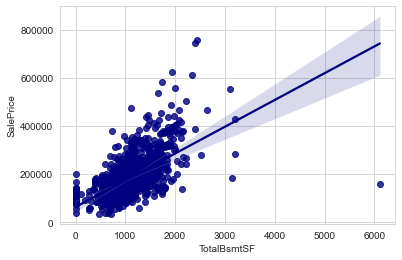

In [8]:
sns.regplot(x = 'TotalBsmtSF', y = 'SalePrice', color = 'navy', data = train)
plt.show()


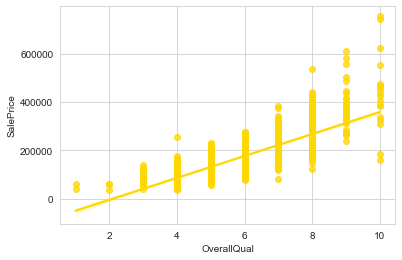

In [9]:
sns.regplot(x = 'OverallQual', y = 'SalePrice', color = 'gold', data = train)
plt.show()
## when you check you price greater then 3.5 or 4 lakhs there is no linearity if you see above and downgraph

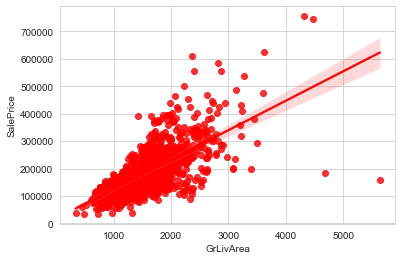

In [10]:
sns.regplot(x = 'GrLivArea', y = 'SalePrice', color = 'red', data = train)
plt.show()
## here also there is linearRelationship between them. but there are some outliars like grlivearea is increasing

In [11]:
## to handle the outliars from the above we droping the values of grlivearea and saleprice
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

<AxesSubplot:>

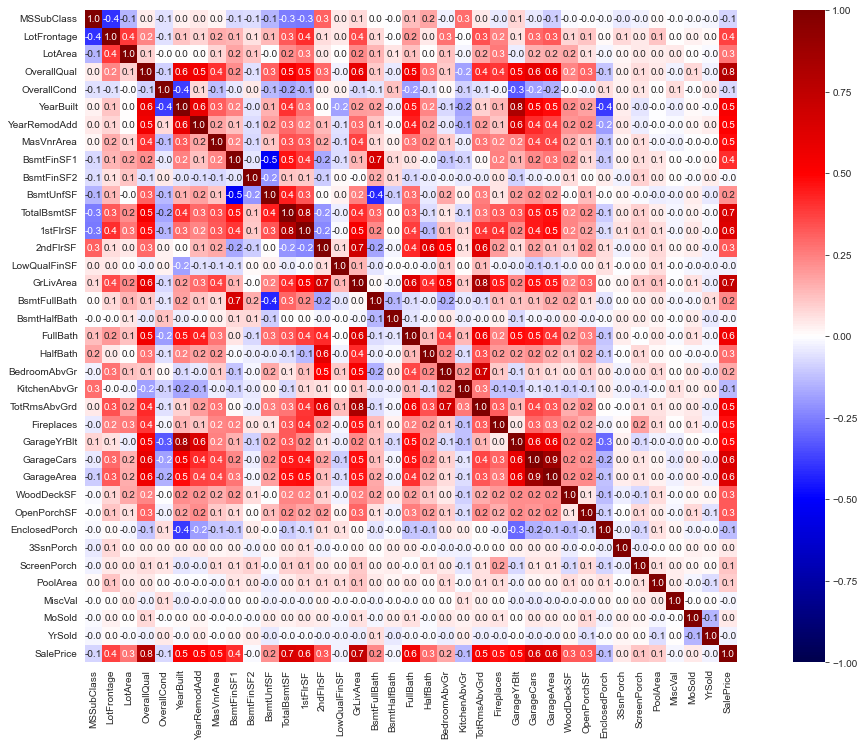

In [12]:
## heatmap is the best way to analize the correlation between the feature and 
## this is correlationmatrix using heatmap 
plt.subplots(figsize=(20,12))
sns.heatmap(train.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, fmt='.1f',square = True)

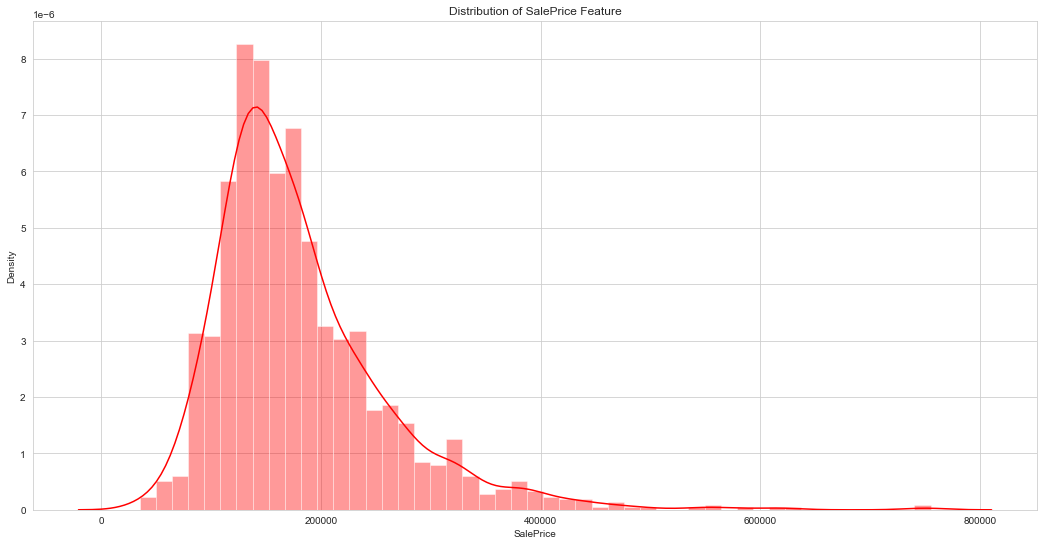

In [13]:
f, ax = plt.subplots(figsize=(18,9))
sns.distplot(train['SalePrice'], color="red")
ax.set(xlabel="SalePrice")
ax.set(title="Distribution of SalePrice Feature")
plt.show()

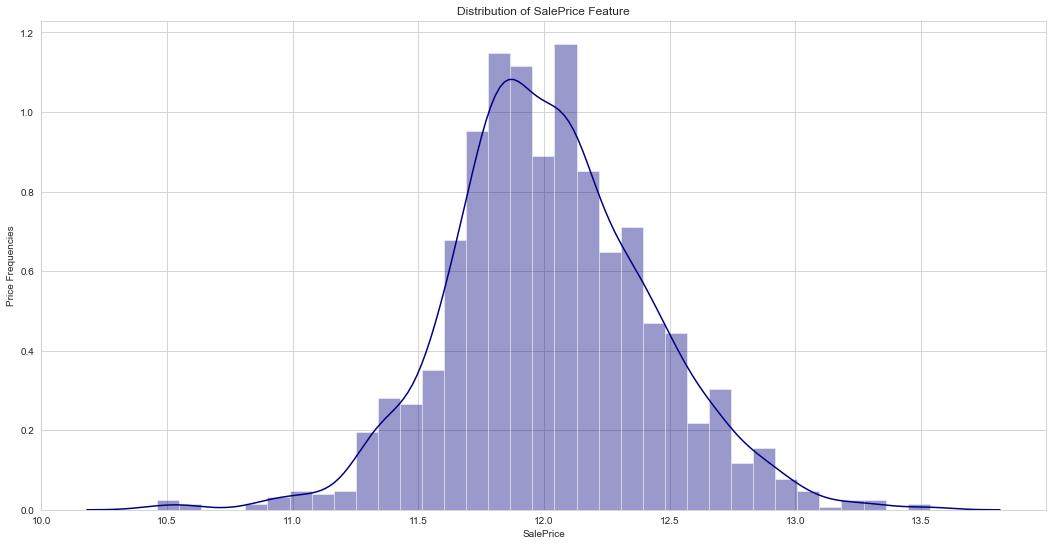

In [14]:
## There seems to be like saleprice is not normally distributed so make it normally distributed 
## we have log1p function
train['SalePrice'] = np.log1p(train['SalePrice'])

f, ax = plt.subplots(figsize=(18,9))
sns.distplot(train['SalePrice'], color="navy")
ax.set(ylabel="Price Frequencies")
ax.set(xlabel="SalePrice")
ax.set(title="Distribution of SalePrice Feature")
plt.show()
## Now the distribution of sale price is like normally distributed

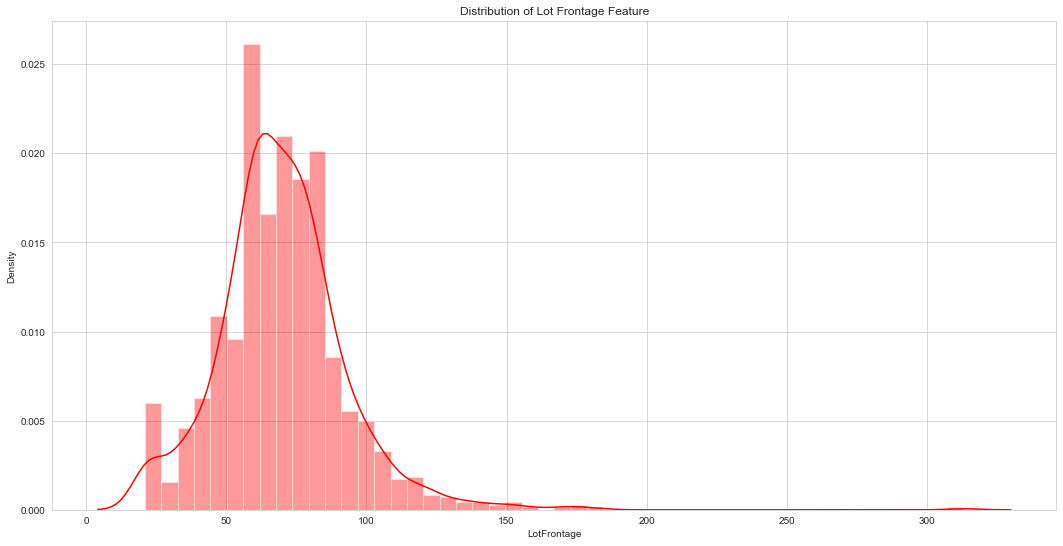

In [15]:
f, ax = plt.subplots(figsize=(18,9))
sns.distplot(train['LotFrontage'], color="red")
ax.set(xlabel="LotFrontage")
ax.set(title="Distribution of Lot Frontage Feature")
plt.show()

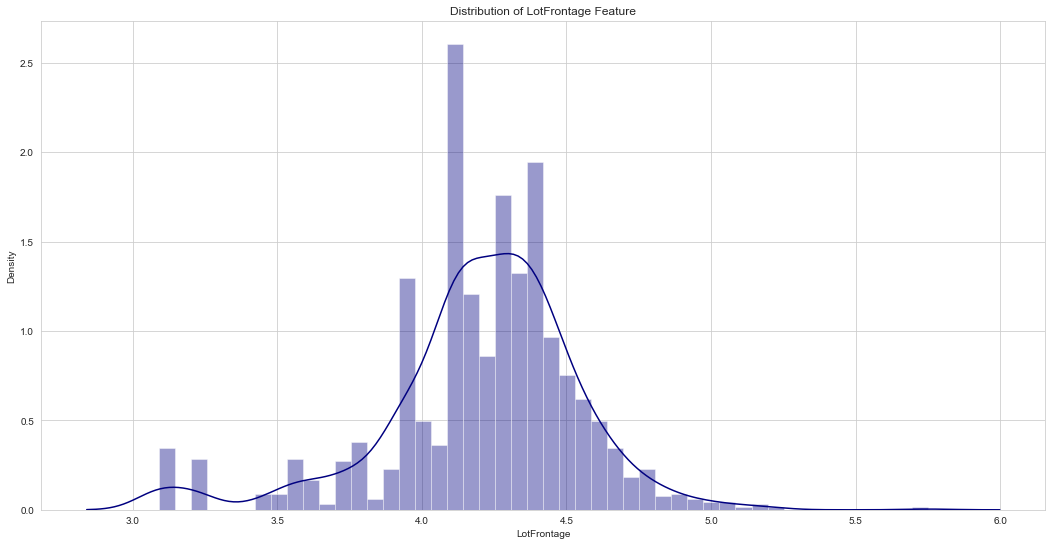

In [16]:
## There seems to be like lotfront is not normally distributed so make it normally distributed 
## we have log1p function

train['LotFrontage'] = np.log1p(train['LotFrontage'])

f, ax = plt.subplots(figsize=(18,9))
sns.distplot(train['LotFrontage'], color="navy")
ax.set(xlabel="LotFrontage")
ax.set(title="Distribution of LotFrontage Feature")
plt.show()

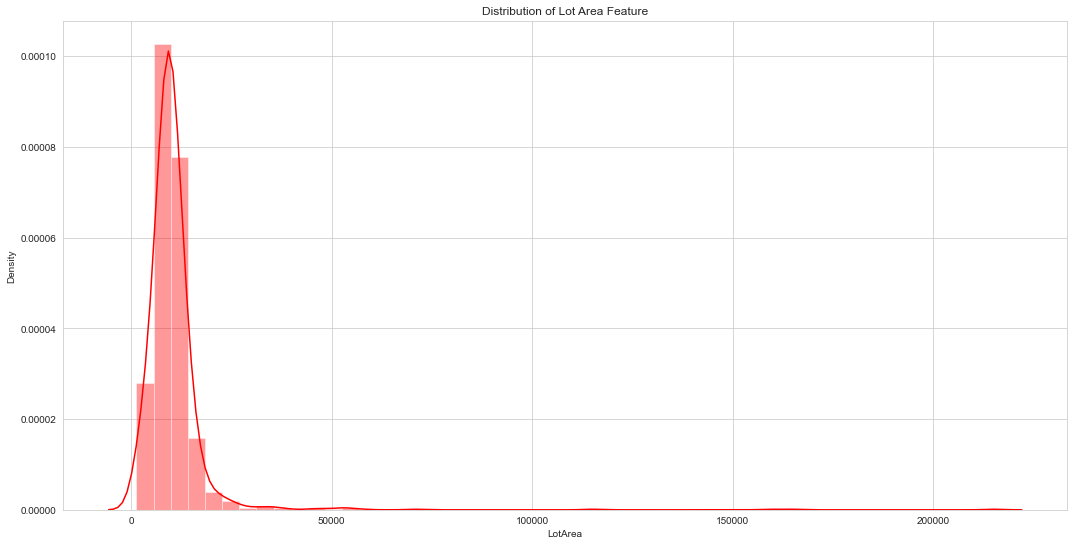

In [17]:
f, ax = plt.subplots(figsize=(18,9))
sns.distplot(train['LotArea'], color="red")
ax.set(xlabel="LotArea")
ax.set(title="Distribution of Lot Area Feature")
plt.show()

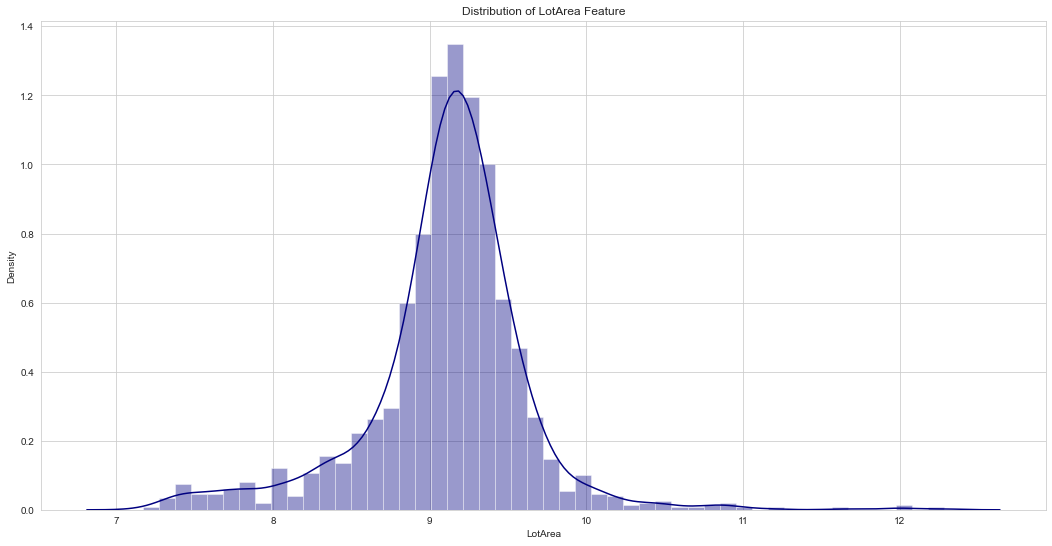

In [18]:
## There seems to be like lotarea is not normally distributed so make it normally distributed 
## we have log1p function
train['LotArea'] = np.log1p(train['LotArea'])

f, ax = plt.subplots(figsize=(18,9))
sns.distplot(train['LotArea'], color="navy")
ax.set(xlabel="LotArea")
ax.set(title="Distribution of LotArea Feature")
plt.show()

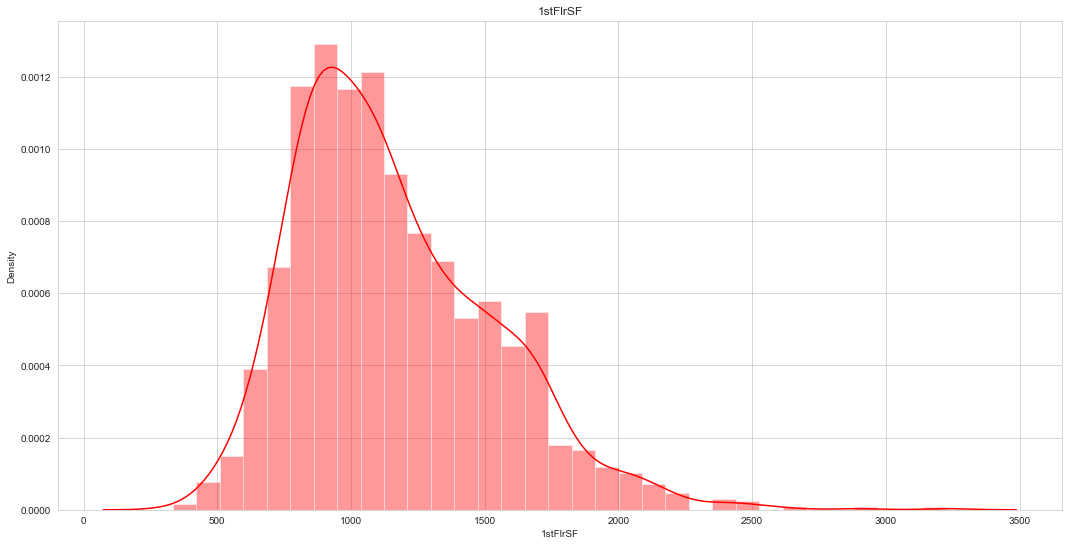

In [19]:
f, ax = plt.subplots(figsize=(18,9))
sns.distplot(train['1stFlrSF'], color="red")
ax.set(xlabel="1stFlrSF")
ax.set(title="1stFlrSF")
plt.show()

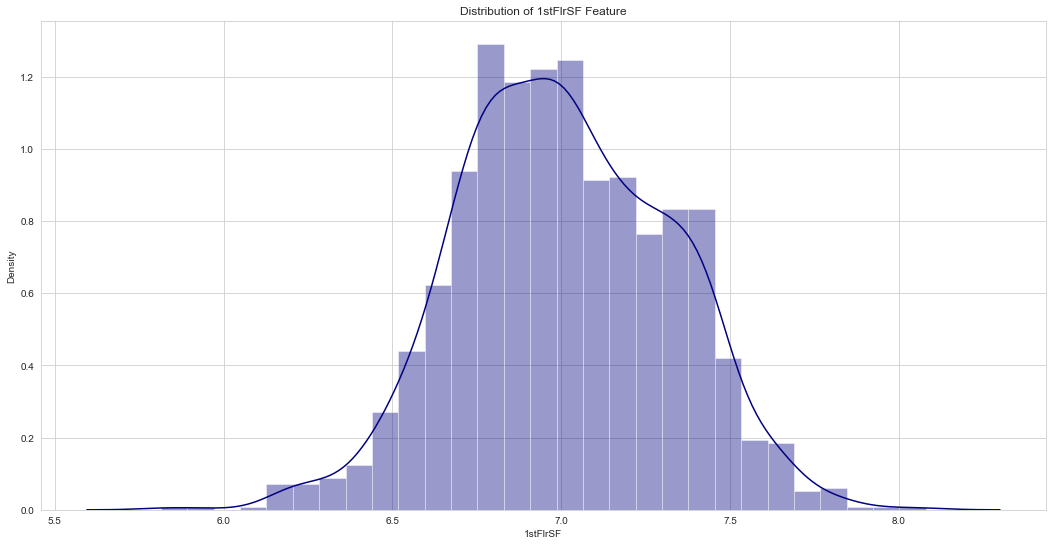

In [20]:
## There seems to be istFleSF is not normally distributed so make it normally distributed 
## we have log1p function
train['1stFlrSF'] = np.log1p(train['1stFlrSF'])

f, ax = plt.subplots(figsize=(18,9))
sns.distplot(train['1stFlrSF'], color="navy")
ax.set(xlabel="1stFlrSF")
ax.set(title="Distribution of 1stFlrSF Feature")
plt.show()

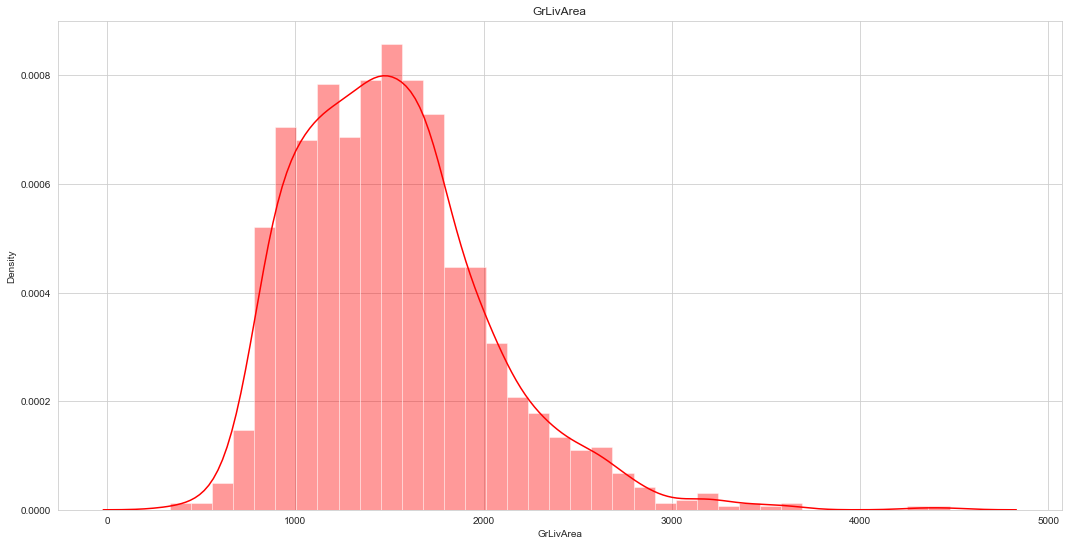

In [21]:
f, ax = plt.subplots(figsize=(18,9))
sns.distplot(train['GrLivArea'], color="red")
ax.set(xlabel="GrLivArea")
ax.set(title="GrLivArea")
plt.show()

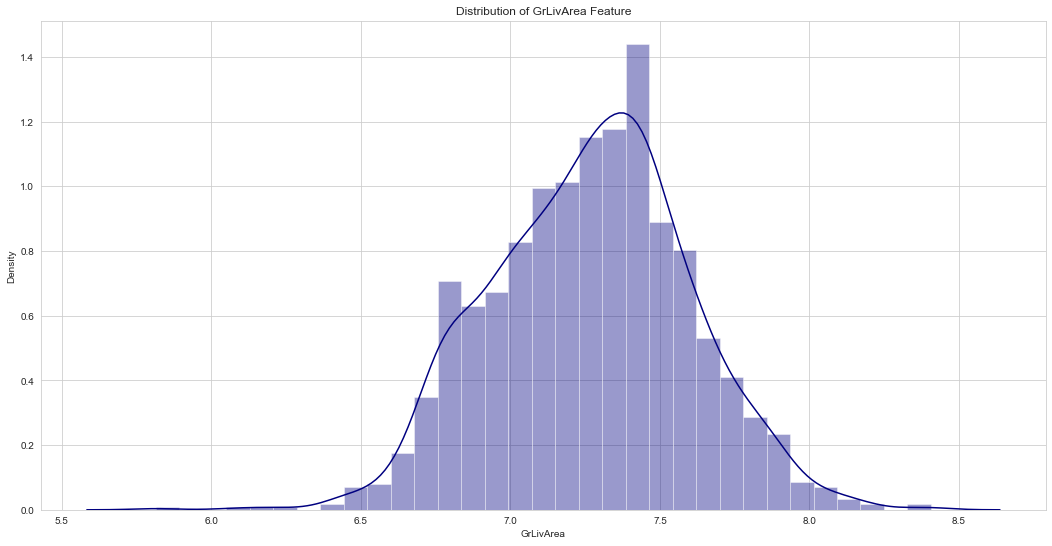

In [22]:
## There seems to be istFleSF is not normally distributed so make it normally distributed 
## we have log1p function

train['GrLivArea'] = np.log1p(train['GrLivArea'])

f, ax = plt.subplots(figsize=(18,9))
sns.distplot(train['GrLivArea'], color="navy")
ax.set(xlabel="GrLivArea")
ax.set(title="Distribution of GrLivArea Feature")
plt.show()

In [23]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
df_new = pd.concat((train, test)).reset_index(drop=True)
df_new.drop(['SalePrice'], axis=1, inplace=True)

# HANDLING THE MISSING VALUES

In [24]:
df_new.isna().sum()

MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
                 ... 
MoSold              0
YrSold              0
SaleType            1
SaleCondition       0
Id               1458
Length: 80, dtype: int64

<AxesSubplot:>

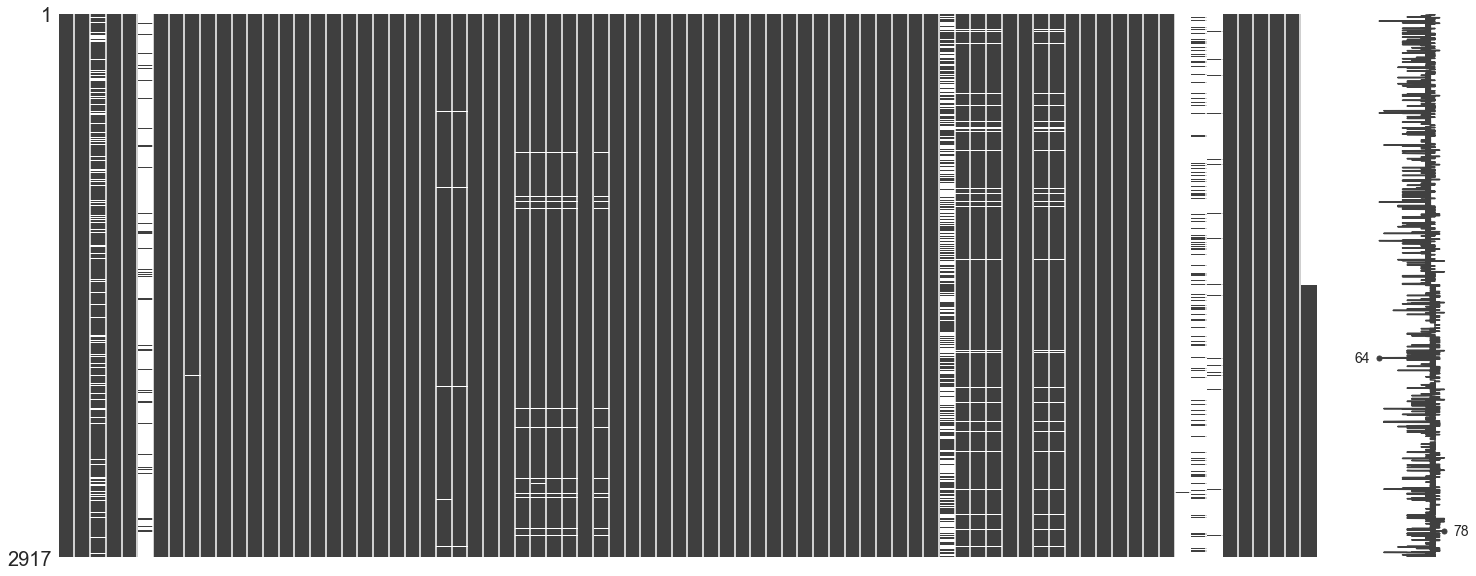

In [25]:
msno.matrix(df_new)

In [26]:
df_new["PoolQC"] = df_new["PoolQC"].fillna("Not Available")
df_new["MiscFeature"] = df_new["MiscFeature"].fillna("Not Available")
df_new["Alley"] = df_new["Alley"].fillna("Not Available")
df_new["FireplaceQu"] = df_new["FireplaceQu"].fillna("Not Available")
df_new["LotFrontage"] = df_new.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
df_new["MasVnrType"] = df_new["MasVnrType"].fillna("Not Available")
df_new["Fence"] = df_new["Fence"].fillna("Not Available")
df_new['SaleType'] = df_new['SaleType'].fillna(df_new['SaleType'].mode()[0])
df_new['MSSubClass'] = df_new['MSSubClass'].fillna("Not Available")
df_new = df_new.drop(['Utilities'], axis=1)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_new[col] = df_new[col].fillna('Not Available')
    
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df_new[col] = df_new[col].fillna('Not Available')

In [27]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df_new[col] = df_new[col].fillna(0)

In [28]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df_new[col] = df_new[col].fillna(0)

In [29]:
df_new["MasVnrArea"] = df_new["MasVnrArea"].fillna(0)

In [30]:
df_new['MSZoning'] = df_new['MSZoning'].fillna(df_new['MSZoning'].mode()[0])
df_new["Functional"] = df_new["Functional"].fillna("Typ")
df_new['Electrical'] = df_new['Electrical'].fillna(df_new['Electrical'].mode()[0])
df_new['KitchenQual'] = df_new['KitchenQual'].fillna(df_new['KitchenQual'].mode()[0])
df_new['Exterior1st'] = df_new['Exterior1st'].fillna(df_new['Exterior1st'].mode()[0])
df_new['Exterior2nd'] = df_new['Exterior2nd'].fillna(df_new['Exterior2nd'].mode()[0])

# FEATURE ENGINEERING

In [31]:
df_new['MSSubClass'] = df_new['MSSubClass'].apply(str)
df_new['OverallCond'] = df_new['OverallCond'].astype(str)
df_new['YrSold'] = df_new['YrSold'].astype(str)
df_new['MoSold'] = df_new['MoSold'].astype(str)

In [32]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

le = LabelEncoder()

for i in cols:
    df_new[i] = le.fit_transform(df_new[[i]])

In [33]:
numeric_feats = df_new.dtypes[df_new.dtypes != "object"].index

skewed_feats = df_new[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})

skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for i in skewed_features:
    df_new[i] = boxcox1p(df_new[i], lam)


Skew in numerical features: 

There are 59 skewed numerical features to Box Cox transform


In [34]:
df_new = pd.get_dummies(df_new)
print(df_new.shape)
train = df_new[:ntrain]
test = df_new[ntrain:]
print(train.shape)
print(test.shape)

(2917, 221)
(1458, 221)
(1459, 221)


In [35]:
gbr = GradientBoostingRegressor(n_estimators=6000,
learning_rate=0.01,
max_depth=4,
max_features='sqrt',
min_samples_leaf=15,
min_samples_split=10,
loss='huber',
random_state=42) 

In [36]:
xgbr = XGBRegressor(learning_rate=0.01,
n_estimators=8000,
max_depth=4,
min_child_weight=0,
gamma=0.6,
subsample=0.7,
colsample_bytree=0.7,
nthread=-1,
scale_pos_weight=1,
seed=27,
reg_alpha=0.00006,
random_state=42)

In [37]:
lgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=6000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

In [38]:
rfr = RandomForestRegressor(n_estimators=7000,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

In [39]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 123).get_n_splits(train.values)

In [40]:
gbr_mse_cv_scores = - cross_val_score(gbr, train.values,y_train,cv = kf, scoring = 'neg_mean_squared_error',n_jobs = -1)
gbr_rmse_score = np.sqrt(gbr_mse_cv_scores)


print('Gradient Boosting Regressor CV RMSE Score :', gbr_rmse_score.mean())


Gradient Boosting Regressor CV RMSE Score : nan


In [41]:
rfr_mse_cv_scores = - cross_val_score(rfr, train.values,y_train,cv = kf, scoring = 'neg_mean_squared_error',n_jobs = -1)
rfr_rmse_score = np.sqrt(rfr_mse_cv_scores)

In [42]:
xgbr_mse_cv_scores = - cross_val_score(xgbr, train.values,y_train,cv = kf, scoring = 'neg_mean_squared_error',n_jobs = -1)
xgbr_rmse_score = np.sqrt(xgbr_mse_cv_scores)

lgbm_mse_cv_scores = - cross_val_score(lgbm, train.values,y_train,cv = kf, scoring = 'neg_mean_squared_error',n_jobs = -1)
lgbm_rmse_score = np.sqrt(lgbm_mse_cv_scores)



In [43]:
print('XGBoost Regressor CV RMSE Score :', xgbr_rmse_score.mean())
print('LightGBM Regressor CV RMSE Score :', lgbm_rmse_score.mean())
print('Random Forest Regressor CV RMSE Score :', rfr_rmse_score.mean())

XGBoost Regressor CV RMSE Score : 0.13777326857727562
LightGBM Regressor CV RMSE Score : 0.11686110936964751
Random Forest Regressor CV RMSE Score : nan


In [44]:
gbr.fit(train, y_train)
gbr_train_pred = gbr.predict(train)
gbr_pred = np.expm1(gbr.predict(test.values))
rmse_gbr = np.sqrt(mean_squared_error(y_train,gbr_train_pred))
print(rmse_gbr)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
xgbr.fit(train,y_train)
xgbr_train_pred = xgbr.predict(train)
xgbr_pred = np.expm1(xgbr.predict(test.values))
rmse_xgbr = np.sqrt(mean_squared_error(y_train,xgbr_train_pred))
print(rmse_xgbr)

In [ ]:
lgbm.fit(train, y_train)
lgbm_train_pred = lgbm.predict(train)
lgbm_pred = np.expm1(lgbm.predict(test.values))
rmse_lgbm = np.sqrt(mean_squared_error(y_train,lgbm_train_pred))
print(rmse_lgbm)

In [ ]:
rfr.fit(train, y_train)
rfr_train_pred = rfr.predict(train)
rfr_pred = np.expm1(rfr.predict(test.values))
rmse_rfr = np.sqrt(mean_squared_error(y_train,rfr_train_pred))
print(rmse_rfr)